# 旅行商问题

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概览

旅行商问题（travelling salesman problem, TSP）是组合优化中最经典的 NP–困难的问题之一，它指的是以下这个问题："已知一系列的城市和它们之间的距离，这个旅行商想造访所有城市各一次，并最后返回出发地，求他的最短路线规划。"

这个问题也可以用图论的语言来描述。已知一个有权重的完全图 $G = (V,E)$。它的每个顶点 $i \in V$ 都对应一个城市 $i$，并且每一条边 $(i,j) \in E$ 的权重 $w_{i,j}$ 对应城市 $i$ 和城市 $j$ 的距离。需要注意的是，$G$ 是个无向图，所以权重是对称的，即 $w_{i,j}=  w_{j,i}$。根据以上定义，旅行商问题可以转化为找这个图中最短的哈密顿回路（Hamiltonian cycle）的问题。哈密顿回路为一个通过且仅通过每一个顶点一次的回路。 

## 使用量子神经网络解旅行商问题

使用量子神经网络方法解决旅行商问题，需要首先将该问题编码为量子形式。
具体的包括以下两部分：

1. 旅行商经过城市的顺序将编码进量子态 —— ${\rm qubit}_{i,t} = |1\rangle$ 对应于在时间 $t$ 经过城市$i$。
    1. 以两城市$\{A,B\}$举例。先经过$A$再经过$B$ 将由$|1001\rangle$表示，对应于旅行商在时间 $1$ 经过城市$A$，在时间 $2$ 经过城市$B$。
    2. 类似的 $|0110\rangle$对应于先经过$B$再经过$A$.
    3. 注意：$|0101\rangle$意味着在时间 $2$ 同时经过城市 $A$、$B$，而这是不可能的。为避免此类量子态，我们会通过引入代价函数的方式 (具体见下一节)。

2. 总距离被编码进损失函数： 

$$
L(\psi(\vec{\theta})) = \langle\psi(\vec{\theta})|H_C|\psi(\vec{\theta})\rangle \, ,
\tag{1}
$$
其中 $|\psi(\vec{\theta})\rangle$ 对应于参数化量子电路的输出。

在下一节中将详细介绍如何编码旅行商问题为对应量子问题。通过优化损失函数，我们将得到对应最优量子态。再通过解码，将得到最终的路线规划

### 编码旅行商问题

为了将旅行商问题转化成一个参数化量子电路（parameterized quantum circuits, PQC）可解的问题，我们首先需要编码旅行商问题的哈密顿量。

我们先将此问题转化为一个整数规划问题：假设图形 $G$ 的顶点数量为 $|V| = n$ 个，那么对于每个顶点 $i \in V$，我们定义 $n$ 个二进制变量 $x_{i,t}$，$t \in [0,n-1]$：

$$
x_{i, t}=
\begin{cases}
1, & \text{如果在最后的哈密顿回路中，顶点 } i \text { 的顺序为 $t$，即在时间 $t$ 的时候被旅行商访问}\\
0, & \text{其他情况}
\end{cases}.
\tag{2}
$$

因为 $G$ 有 $n$ 个顶点，所以我们共有 $n^2$ 个变量 $x_{i,t}$，所有这些变量的取值我们用 $x=x_{1,1}x_{1,2}\dots x_{n,n}$ 来表示。现在我们假设 $x$ 对应了一条哈密顿回路，那么对于图中的每一条边 $(i,j,w_{i,j}) \in E$，条件 $x_{i,t} = x_{j,t+1} = 1$（也可以等价地写成 $x_{i,t}\cdot x_{j,t+1} = 1$）成立当且仅当该哈密顿回路中的第 $t$ 个顶点是顶点 $i$ 并且第 $t+1$ 个顶点是顶点 $j$；否则，$x_{i,t}\cdot x_{j,t+1} = 0$。所以我们可以用下式计算哈密顿回路的长度

$$
D(x) = \sum_{i,j} w_{i,j} \sum_{t} x_{i,t} x_{j,t+1}.
\tag{3}
$$

根据哈密顿回路的定义，$x$ 如果对应一条哈密顿回路需要满足如下的限制：

$$
\sum_t x_{i,t} = 1 \quad  \forall i \in [0,n-1] \quad \text{ 和 } \quad \sum_i x_{i,t} = 1 \quad  \forall t \in [0,n-1],
\tag{4}
$$

其中第一个式子用来保证找到的 $x$ 所代表的路线中每个顶点仅出现一次，第二个式子保证在每个时间只有一个顶点可以出现。这两个式子共同保证了参数化量子电路找到的 $x$ 是个哈密顿回路。所以，我们可以定义在此限制下的代价函数：

$$
C(x) = D(x)+ A\left( \sum_{i} \left(1-\sum_t  x_{i,t}\right)^2 +  \sum_{t} \left(1-\sum_i  x_{i,t}\right)^2  \right).
\tag{5}
$$

其中 $A$ 是惩罚参数，它保证了上述的限制被遵守。因为我们想要在找哈密顿回路的长度 $D(x)$ 的最小值的同时保证 $x$ 确实表示一个哈密顿回路，所以我们需要设置一个大一点的 $A$，最起码大过图 $G$ 中边的最大的权重，从而保证不遵守限制的路线不会成为最终的路线。

我们现在需要将代价函数 $C(x)$ 转化为一个哈密顿量从而完成旅行商问题的编码。每一个二进制变量可以取0和1两个值，分别对应量子态 $|0\rangle$ 和 $|1\rangle$。**每个二进制变量都对应一个量子比特，所以我们需要 $n^2$ 个量子比特来解决旅行商问题。** 和最大割问题相似，因为泡利 $Z$ 的两个本征态和我们需要的量子态 $|0\rangle$、$|1\rangle$ 一样，这两个本征态所对应的本征值分别是 1 和 -1，所以我们考虑利用泡利 $Z$ 矩阵将代价函数编码为哈密顿量。

我们现在将二进制变量映射到泡利 $Z$ 矩阵上，从而使 $C(x)$ 转化成哈密顿矩阵：

$$
x_{i,t} \mapsto \frac{I-Z_{i,t}}{2}, \tag{6}
$$

这里 $Z_{i,t} = I \otimes I \otimes \ldots \otimes Z \otimes \ldots \otimes I$，也就是说 $Z$ 作用在位置在 $(i,t)$ 的量子比特上。通过这个映射，如果一个编号为 $(i,t)$ 的量子比特的量子态为 $|1\rangle$，那么对应的二进制变量的取值为 $x_{i,t} |1\rangle = \frac{I-Z_{i,t}}{2} |1\rangle = 1 |1\rangle$，也就是说顶点 $i$ 在最短哈密顿回路中的位置是 $t$。同样地，对于量子态为 $|0\rangle$的量子比特 $(i,t)$，它所对应的二进制变量的取值为 $x_{i,t} |0\rangle = \frac{I-Z_{i,t}}{2} |0\rangle = 0 |0\rangle$。

我们用上述映射将 $C(x)$ 转化成量子比特数为 $n^2$ 的系统的哈密顿矩阵 $H_C$，从而实现了旅行商问题的量子化。这个哈密顿矩阵 $H_C$ 的基态即为旅行商问题的最优解。在接下来的章节中，我们将展示怎么用参数化量子电路找到这个矩阵的基态，即对应最小本征值的本征态。

## Paddle Quantum 实现

要在量桨上实现用参数化量子电路解决旅行商问题，首先要做的便是加载需要用到的包。其中 `networkx` 包可以帮助我们方便地处理图。

In [8]:
# 加载量桨、飞桨的相关模块
import paddle
import paddle_quantum
from paddle_quantum.ansatz import Circuit
from paddle_quantum import Hamiltonian

# 旅行商问题相关函数
from paddle_quantum.QAOA.tsp import tsp_hamiltonian  # 构造旅行商问题哈密顿量的函数
from paddle_quantum.QAOA.tsp import solve_tsp_brute_force  # 暴力求解旅行商问题

# 用于生成图
import networkx as nx

# 加载额外需要用到的包
from numpy import pi as PI
import matplotlib.pyplot as plt
import random
import time

### 生成该旅行商问题中的图 

接下来，我们生成该旅行商问题中的图 $G$。为了运算方便，图中的顶点从0开始计数。

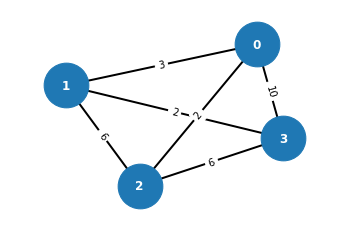

In [9]:
# n 代表图形 G 的顶点数量
n = 4
E = [(0, 1, 3), (0, 2, 2), (0, 3, 10), (1, 2, 6), (1, 3, 2), (2, 3, 6)]  # 线段参数(顶点1， 顶点2， 权重(距离))
G = nx.Graph()
G.add_weighted_edges_from(E)

# 将生成的图 G 打印出来
pos = nx.spring_layout(G)
options = {
    "with_labels": True,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 2000,
    "width": 2
}
nx.draw_networkx(G, pos, **options)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G,'weight'))
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

### 编码哈密顿量

量桨中，哈密顿量可以以 ``list`` 的形式输入。这里我们将式（4）中的二进制变量用式（5）替换，从而构建哈密顿量 $H_C$。具体的形式可以通过内置函数 tsp_hamiltonian(G, A, n)直接得到。

**注意：** 对于旅行商问题，由于我们总可以选定某一个城市为第一个抵达的城市，故实际所需量子比特数可以从 $n^2$ 降到了 $(n-1)^2$。在我们接下来的实现当中都会使用改进过的哈密顿量来计算。

In [10]:
# 以 list 的形式构建哈密顿量 H_C -- 通过内置函数tsp_hamiltonian(G, A, n)
A = 20 # 惩罚参数
H_C_list = tsp_hamiltonian(G, A, n)
# 生成哈密顿量
H_C = Hamiltonian(H_C_list)

### 计算损失函数

在最大割问题（[Max-Cut 教程](./MAXCUT_CN.ipynb)）中，我们用 QAOA 构建了我们的参数化量子电路，但除了 QAOA 电路，其他的电路也可以用来解决组合优化问题。对于旅行商问题，我们将使用 $U_3(\vec{\theta})$ 和 $\text{CNOT}$ 门构造的参数化量子电路。这可以通过调用量桨内部的 [`complex entangled layer`](https://qml.baidu.com/api/paddle_quantum.circuit.uansatz.html) 来实现。

<img src="./figures/tsp-fig-circuit.png" width="900px" /> 
<center> 图 1: 旅行商问题使用的参数化电路 </center>

上述电路会给出一个输出态 $|\psi(\vec{\theta})\rangle$，由此输出态，我们可以计算最大割问题的目标函数，也就是旅行商问题的损失函数：

$$
L(\psi(\vec{\theta})) = \langle\psi(\vec{\theta})|H_C|\psi(\vec{\theta})\rangle.
\tag{7}
$$

然后我们利用经典的优化算法寻找最优参数 $\vec{\theta}^*$。下面的代码给出了通过量桨和飞桨搭建的完整网络：

In [11]:
# 此处使用内置量子电路：complex_entangled_layer()
def cir_TSP(N: int, DEPTH: int) -> Circuit:
    cir = Circuit(N)
    cir.complex_entangled_layer(depth=DEPTH)
    return cir

In [12]:
# 定义损失函数
def loss_func(cir: Circuit, H: Hamiltonian) -> paddle.Tensor:
    state = cir()
    loss = paddle_quantum.loss.ExpecVal(H)
    return loss(state)

### 训练量子神经网络

定义好了量子神经网络后，我们使用梯度下降的方法来更新其中的参数，使得式（7）的期望值最小。

In [13]:
DEPTH = 2      # 量子电路的层数
ITR = 120      # 训练迭代的次数
LR = 0.5       # 基于梯度下降的优化方法的学习率
SEED = 1000    #设置随机数种子

这里，我们在飞桨中优化上面定义的网络。

In [14]:
# 固定 paddle 随机种子
paddle.seed(SEED)
# 记录运行时间
time_start = time.time()

# 总qubit数取为：(城市数-1)**2
num_qubits = (len(G) - 1) ** 2

# 创建电路
cir = cir_TSP(num_qubits, DEPTH)

# 使用 Adam 优化器
opt = paddle.optimizer.Adam(learning_rate=LR, parameters=cir.parameters())

# 梯度下降循环
for itr in range(1, ITR + 1):
    # 计算梯度并优化
    loss = loss_func(cir, H_C)
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()
    # 输出迭代中performance
    if itr % 10 == 0:
        print("循环数:", itr, "损失:", "%.4f"% loss.numpy(), "用时:", time.time()-time_start)

# 显示QNN得到最小路程
print('得到最小路程:', loss.numpy())

循环数: 10 损失: 46.0240 用时: 1.7304351329803467
循环数: 20 损失: 22.6653 用时: 3.757274627685547
循环数: 30 损失: 16.6194 用时: 5.594370603561401
循环数: 40 损失: 14.3720 用时: 7.301747560501099
循环数: 50 损失: 13.5547 用时: 9.344748735427856
循环数: 60 损失: 13.1736 用时: 11.30988073348999
循环数: 70 损失: 13.0661 用时: 13.120512962341309
循环数: 80 损失: 13.0219 用时: 14.732549905776978
循环数: 90 损失: 13.0035 用时: 16.409778356552124
循环数: 100 损失: 13.0033 用时: 18.174597024917603
循环数: 110 损失: 13.0008 用时: 19.95359969139099
循环数: 120 损失: 13.0004 用时: 21.790847778320312
得到最小路程: [13.000355]


最理想的情况是我们使用的量子神经网络可以找到最短哈密顿回路，同时最后的损失值应该等于这条回路上的权重之和，即旅行商所需要走的最短长度。但如果最后的情况不是这样，读者可以通过调整参数化量子电路的参数值，即 DEPTH，ITR 和 LR，来获得更好的训练效果。

### 解码量子答案

当求得损失函数的最小值以及相对应的一组参数 $\vec{\theta}^*$后，我们的任务还没有完成。为了进一步求得旅行商问题的近似解，需要从电路输出的量子态 $|\psi(\vec{\theta})^*\rangle$ 中解码出经典优化问题的答案。物理上，解码量子态需要对量子态进行测量，然后统计测量结果的概率分布（我们的测量结果是表示旅行商问题答案的比特串）：

$$
p(z) = |\langle z|\psi(\vec{\theta})^*\rangle|^2.
\tag{8}
$$

通常情况下，某个比特串出现的概率越大，意味着其对应旅行商问题最优解的可能性越大。

量桨提供了查看参数化量子电路输出状态的测量结果概率分布的函数：

In [15]:
# 模拟重复测量电路输出态 1024 次
state = cir()
prob_measure = state.measure(shots=1024)
reduced_salesman_walk = max(prob_measure, key=prob_measure.get)
print("利用改进后的哈密顿量找到的解的比特串形式：", reduced_salesman_walk)

利用改进后的哈密顿量找到的解的比特串形式： 010001100


因为我们之前为了减少所需要的量子比特数改进了一下旅行商问题对应的哈密顿量，上面显示的比特串缺少了顶点 $n-1$ 的信息，以及所有顶点在时间 $t =n-1$ 的时候的信息。所以我们需要将这些信息加回找到的比特串中。

首先为了加上对于 $i \in [0，n-2]$， $x_{i,n-1} = 0$ 这一信息，我们需要在每 $(n-1)$ 个比特之后加上一个 $0$。接着在比特串的最后，我们为了加上顶点 $n-1$在每个时间的状态，我们加上包含 $n-1$ 个 '0' 的 '00...01'，用来表示对于$t \in [0,n-2]$来说，$x_{n-1,t} = 0$，同时 $x_{n-1,n-1} = 0$。

以下代码通过测量，找到了出现几率最高的比特串，每一个比特都包含了式（1）定义的 $x_{i,t}$ 的信息。我们将找到的比特串映射回经典解，即转化成了 ``dictionary`` 的形式。其中 ``key`` 代表顶点编号，``value`` 代表顶点在哈密顿回路中的顺序，即访问城市的顺序。在以下代码中，我们还将量子电路找到的最优解和暴力算法找到的相比较，从而说明量子算法的正确性。

In [16]:
# 参数化量子电路找到的最优解
str_by_vertex = [reduced_salesman_walk[i:i + n - 1] for i in range(0, len(reduced_salesman_walk) + 1, n - 1)]
salesman_walk = '0'.join(str_by_vertex) + '0' * (n - 1) + '1'
solution = {i:t for i in range(n) for t in range(n) if salesman_walk[i * n + t] == '1'}
distance = sum([G[u][v]["weight"] if solution[u] == (solution[v] + 1) % n 
                or solution[v] == (solution[u] + 1) % n else 0
                for (u, v) in G.edges])
print("参数化量子电路找到的最优解：", solution, "，最短距离为：", distance)

# 经典暴力算法找到的最优解
salesman_walk_brute_force, distance_brute_force = solve_tsp_brute_force(G)
solution_brute_force = {i:salesman_walk_brute_force.index(i) for i in range(n)}
print("经典暴力算法找到的最优解：", solution_brute_force, "，最短距离为：", distance_brute_force)

参数化量子电路找到的最优解： {0: 1, 1: 2, 2: 0, 3: 3} ，最短距离为： 13
经典暴力算法找到的最优解： {0: 0, 1: 1, 2: 3, 3: 2} ，最短距离为： 13


以下的代码将字典形式的经典解用图的形式展示了出来：
* 顶点中的第一个数字代表城市编号
* 顶点中的第二个数字代表旅行商访问此城市的顺序
* 红色的边表示找到的最佳路线

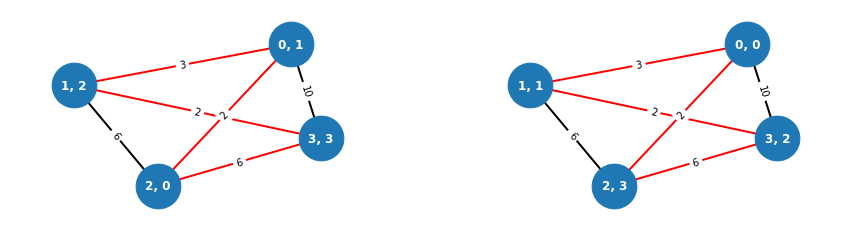

In [17]:
label_dict = {i: str(i) + ", " + str(t) for i, t in solution.items()}
edge_color = ["red" if solution[u] == (solution[v] + 1) % n
              or solution[v] == (solution[u] + 1) % n else "black"
              for (u, v) in G.edges]
label_dict_bf = {i: str(i) + ", " + str(t) for i, t in solution_brute_force.items()}
edge_color_bf = ["red" if solution_brute_force[u] == (solution_brute_force[v] + 1) % n
                 or solution_brute_force[v] == (solution_brute_force[u] + 1) % n else "black"
                 for (u, v) in G.edges]

# 在图上画出上面得到的最优路线
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i, a in enumerate(ax):
    a.axis('off')
    a.margins(0.20)
nx.draw(G, pos=pos, labels=label_dict, edge_color=edge_color, ax=ax[0], **options)
nx.drawing.nx_pylab.draw_networkx_edge_labels(G, pos=pos, ax=ax[0], edge_labels=nx.get_edge_attributes(G, 'weight'))
nx.draw(G, pos=pos, labels=label_dict_bf, edge_color=edge_color_bf, ax=ax[1], **options)
nx.drawing.nx_pylab.draw_networkx_edge_labels(G, pos=pos, ax=ax[1], edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.axis("off")
plt.show()

上面给出的左图展示了参数化量子电路找到的旅行商问题的最优解，右图展示了经典暴力算法找到的最优解。我们不难看出，即使旅行商访问每个城市的绝对顺序不一样，但路线是一致的，即相对顺序一样。这说明在这个例子中，参数化量子电路找到了旅行商问题的最优解。

##  实际应用

旅行商问题可以直接应用在很多交通和物流规划中，例如规划校车接送学生的路线。管理科学领域的先锋 Merrill Flood 在上世纪40年代就受到校车问题的启发，展开了对于旅行商问题的早期研究。更多近期的应用包括了路线规划 [1] 和电线公司对于电力传输的规划 [2]。

除了交通运输问题，旅行商问题同样在管理问题中有很广泛的应用，比如计划机器在电路板上钻孔的顺序 [3]、重构 DNA 上的不明片段 [4] 以及规划最佳建筑路线 [5]。 一些咨询公司，比如 [Nexus](https://nexustech.com.ph/company/newsletter/article/Finding-the-shortest-path-Optimizing-food-trips) 也通过旅行商问题给外界提供管理咨询服务。

同时作为最著名的组合优化问题之一，旅行商问题为很多用于解决组合问题的通用算法提供了测试平台。它经常被作为研究者测试他们提出的新的算法的首选例子。

对于旅行商问题更多的应用和解法，详见 [6]。

_______

## 参考文献

[1] Bräysy, Olli, et al. "An optimization approach for communal home meal delivery service: A case study." [Journal of Computational and Applied Mathematics 232.1 (2009): 46-53.](https://www.sciencedirect.com/science/article/pii/S0377042708005438)

[2] Sloane, Thomas H., Frank Mann, and H. Kaveh. "Powering the last mile: an alternative to powering FITL." [Proceedings of Power and Energy Systems in Converging Markets. IEEE, 1997.](https://ieeexplore.ieee.org/document/646046)

[3] Onwubolu, Godfrey C. "Optimizing CNC drilling machine operations: traveling salesman problem-differential evolution approach." [New optimization techniques in engineering. Springer, Berlin, Heidelberg, 2004. 537-565.](https://link.springer.com/chapter/10.1007/978-3-540-39930-8_22)

[4] Caserta, Marco, and Stefan Voß. "A hybrid algorithm for the DNA sequencing problem." [Discrete Applied Mathematics 163 (2014): 87-99.](https://www.sciencedirect.com/science/article/pii/S0166218X12003253)

[5] Klanšek, Uroš. "Using the TSP solution for optimal route scheduling in construction management." [Organization, technology & management in construction: an international journal 3.1 (2011): 243-249.](https://www.semanticscholar.org/paper/Using-the-TSP-Solution-for-Optimal-Route-Scheduling-Klansek/3d809f185c03a8e776ac07473c76e9d77654c389)

[6] Matai, Rajesh, Surya Prakash Singh, and Murari Lal Mittal. "Traveling salesman problem: an overview of applications, formulations, and solution approaches." [Traveling salesman problem, theory and applications 1 (2010).](https://www.sciencedirect.com/topics/computer-science/traveling-salesman-problem)